In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
filterwarnings('ignore')

from validation.shared.validation_utils import read_pickle
from validation.shared.dataset_paths import real_set_path

%matplotlib inline

In [2]:
real_set_df = read_pickle(real_set_path)

# Kmean Algorithm
> Kmeans algorithm is an __iterative algorithm__ that __tries to partition the dataset into K pre-defined distinct non-overlapping subgroups (clusters)__ where each data point belongs to only one group. It tries to make the inter-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. __It assigns data points to a cluster such that the sum of the squared distance between the data points__ and the cluster's centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

## How it works
1. Specify number of clusters K.
2. Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn't changing.


- Compute the sum of the squared distance between data points and all centroids.
- Assign each data point to the closest cluster (centroid).
- Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.



## Few Things to notice

- Since clustering algorithms including __kmeans use distance-based measurements to determine the similarity__ between data points, it's recommended __to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements__ such as age vs income.
- Given kmeans iterative nature and the random initialization of centroids at the start of the algorithm, __different initializations may lead to different clusters__ since kmeans algorithm may stuck in a local optimum and may not converge to global optimum. Therefore, it’s recommended to run the algorithm using different initializations of centroids and pick the results of the run that that yielded the lower sum of squared distance.
- Assignment of examples isn't changing is the same thing as no change in within-cluster variation

## Implementation

In [3]:
def standardize(sequence):
    u = np.mean(sequence, axis = 1).reshape(-1, 1)
    s = np.std(sequence, axis = 1).reshape(-1, 1)

    sequence = (sequence - u) / s

    idx = np.sum(np.isnan(sequence), axis = 1) == 0
    sequence = sequence[idx, :]
    
    return sequence, idx

def loss(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    
    return accuracy, precision, recall


def kmean_clustering(n_iter, n_clusters):
    
    fig, ax = plt.subplots(3, 3, figsize=(20, 20))
    ax = np.ravel(ax)

    for i in range(n_iter):
        sequence = np.array(real_set_df['sequence'].values.tolist())
        sequence, idx = standardize(sequence)

        kmean = KMeans(
            n_clusters=n_clusters, 
            random_state=np.random.randint(0, 1000, size=1)[0], 
            max_iter=256
        )
        
        kmean.fit(sequence)
        km_idx = kmean.predict(sequence)

        #accuracy, precision, recall = loss(real_set_df.abnormal_yn.values[idx], km_idx)

        ax[i].scatter(sequence[km_idx == 0, 0], sequence[km_idx == 0, 1],
                      c='blue', label='normal')

        ax[i].scatter(sequence[km_idx == 1, 0], sequence[km_idx == 1, 1],
                      c='red', label='abnormal')
        #kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], marker='*', s=150, c='black'
        ax[i].scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1],
                      c='black', marker='*', s=300, label='centroid')

        #ax[i].set_xlim([-2, 2])
        #ax[i].set_ylim([-2, 2])
        ax[i].legend(loc='lower right')
        #ax[i].set_title(f'accuracy:{accuracy}')
        ax[i].set_aspect('equal')

    plt.tight_layout()

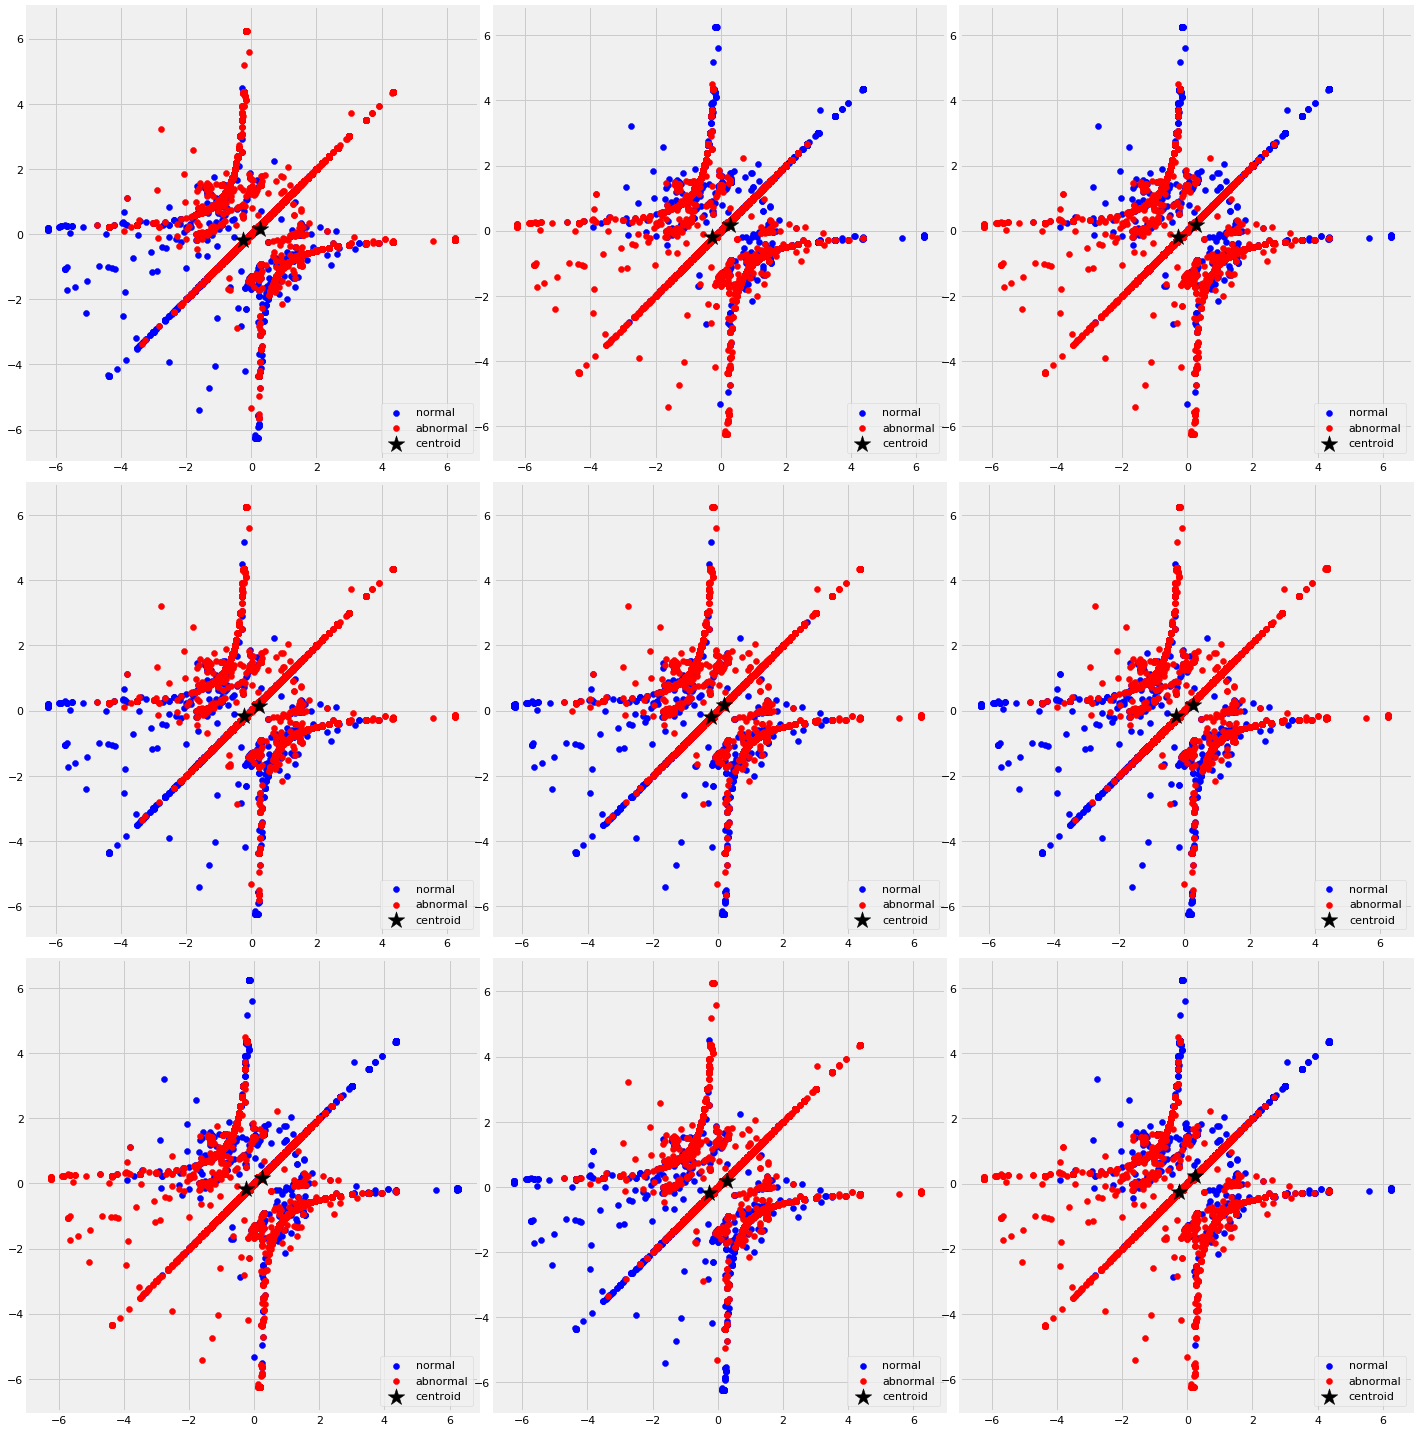

In [52]:
kmean_clustering(n_iter=9, n_clusters=2)

## Evaluation Methods

Contrary to supervised learning where we have the ground truth to evaluate the model's performance, __clustering analysis doesn't have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms.__ Moreover, __since kmeans requires k as an input and doesn't learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem.__ Sometimes domain knowledge and intuition may help but usually that is not the case. In the cluster-predict methodology, we can evaluate how well the models are performing based on different K clusters since clusters are used in the downstream modeling.

### Elbow Method

Elbow method gives us an __idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters centroids.__ We pick k at the spot where SSE starts to flatten out and forming an elbow. We'll use the geyser dataset and evaluate SSE for different values of k and see where the curve might form an elbow and flatten out.

In [4]:
def find_optimal_k():
    
    list_k = list(range(2, 38))
    sse = []
    
    sequence = np.array(real_set_df['sequence'].values.tolist())
    sequence, idx = standardize(sequence)
    
    for k in list_k:
        kmean = KMeans(
            n_clusters=k
        )
        
        kmean.fit(sequence)
        sse.append(kmean.inertia_)
    
    plt.figure(figsize=(16,8))
    plt.grid(True)
    plt.plot(list_k, sse, '-o', c = 'black')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum Of Squared Distance');
    
    plt.show()

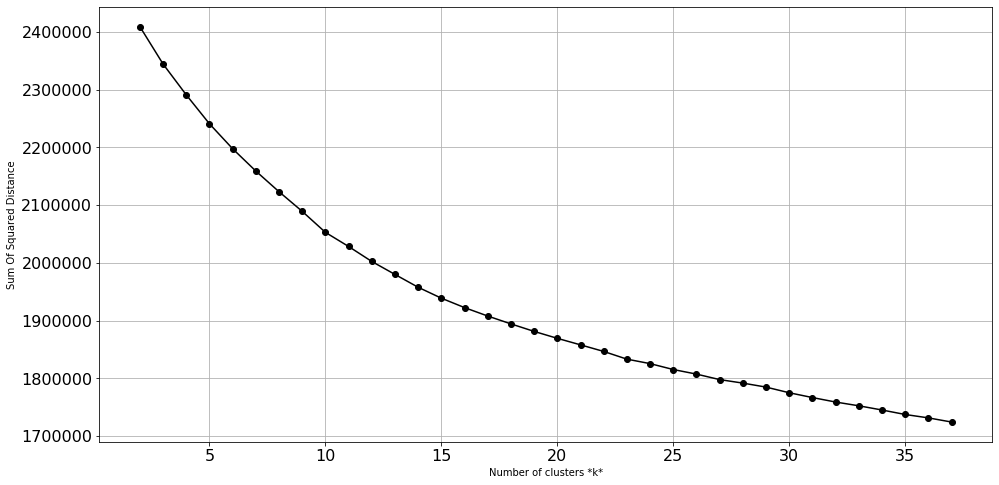

In [5]:
find_optimal_k()